In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

code = 'sh.600036'
new_df = pd.read_csv(f'{code}_history_data.csv', index_col=0)
new_df['EMA_9'] = new_df['close'].ewm(9).mean().shift()
new_df['SMA_5'] = new_df['close'].rolling(5).mean().shift()
new_df['SMA_10'] = new_df['close'].rolling(10).mean().shift()
new_df['SMA_15'] = new_df['close'].rolling(15).mean().shift()
new_df['SMA_30'] = new_df['close'].rolling(30).mean().shift()

def calculate_macd(data, short_period, long_period, signal_period):
    short_ema = data.ewm(span=short_period, adjust=False).mean()
    long_ema = data.ewm(span=long_period, adjust=False).mean()
    macd_line = short_ema - long_ema
    signal_line = macd_line.ewm(span=signal_period, adjust=False).mean()
    return macd_line, signal_line

def calculate_rsi(data, period):
    delta = data.diff()
    gains = delta.where(delta > 0, 0)
    losses = -delta.where(delta < 0, 0)
    
    avg_gain = gains.rolling(window=period, min_periods=1).mean()
    avg_loss = losses.rolling(window=period, min_periods=1).mean()
    
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_wpr(data, period):
    highest_high = data.rolling(window=period, min_periods=1).max()
    lowest_low = data.rolling(window=period, min_periods=1).min()
    wpr = (highest_high - data) / (highest_high - lowest_low) * -100
    return wpr

# Calculate MACD
short_period = 12
long_period = 26
signal_period = 9
new_df['MACD'], new_df['Signal_Line'] = calculate_macd(new_df['close'], short_period, long_period, signal_period)

# Calculate RSI
rsi_period = 14
new_df['RSI'] = calculate_rsi(new_df['close'], rsi_period)

# Calculate WPR
wpr_period = 14
new_df['WPR'] = calculate_wpr(new_df['close'], wpr_period)

print(new_df)

                 code   open   high    low  close     volume        amount  \
date                                                                         
2018-01-02  sh.600036  29.02  30.06  29.02  29.62   67591307  2.009147e+09   
2018-01-03  sh.600036  29.74  30.48  29.64  29.97   71850339  2.161449e+09   
2018-01-04  sh.600036  30.28  30.36  29.40  29.65   51686593  1.540870e+09   
2018-01-05  sh.600036  29.87  30.25  29.46  30.10   47990820  1.435733e+09   
2018-01-08  sh.600036  29.92  30.05  29.31  29.47   65857890  1.943542e+09   
...               ...    ...    ...    ...    ...        ...           ...   
2023-07-26  sh.600036  33.27  33.73  33.07  33.35   50175140  1.673625e+09   
2023-07-27  sh.600036  33.50  33.82  33.20  33.66   54848896  1.845231e+09   
2023-07-28  sh.600036  33.49  35.29  33.41  35.10  125628759  4.358344e+09   
2023-07-31  sh.600036  35.52  36.04  35.01  35.56  116275605  4.127807e+09   
2023-08-01  sh.600036  35.53  35.58  34.77  34.99   66009585  2.

In [2]:
df = new_df[['close','high','low','EMA_9','pctChg']].copy()
print(df)

            close   high    low      EMA_9    pctChg
date                                                
2018-01-02  29.62  30.06  29.02        NaN  0.020675
2018-01-03  29.97  30.48  29.64  29.620000  0.011816
2018-01-04  29.65  30.36  29.40  29.804211 -0.010677
2018-01-05  30.10  30.25  29.46  29.747306  0.015177
2018-01-08  29.47  30.05  29.31  29.849863 -0.020930
...           ...    ...    ...        ...       ...
2023-07-26  33.35  33.73  33.07  32.344340  0.002405
2023-07-27  33.66  33.82  33.20  32.444906  0.009295
2023-07-28  35.10  35.29  33.41  32.566415  0.042781
2023-07-31  35.56  36.04  35.01  32.819774  0.013105
2023-08-01  34.99  35.58  34.77  33.093796 -0.016029

[1355 rows x 5 columns]


In [3]:
def Stock_Price_LSTM_Data_Precesing(df,mem_his_days,pre_days):
    df.dropna(inplace=True)
    df.sort_index(inplace=True)

    df['label'] = df['close'].shift(-pre_days)

    from sklearn.preprocessing import StandardScaler
    scaler_x = StandardScaler()
    scaler_y = StandardScaler()
    sca_X = scaler_x.fit_transform(df.iloc[:,:-1])

    from collections import deque
    deq = deque(maxlen=mem_his_days)

    X = []
    for i in sca_X:
        deq.append(list(i))
        if len(deq)==mem_his_days:
            X.append(list(deq))

    X_lately = X[-pre_days:]
    X = X[:-pre_days]

    y = df['label'].values[mem_his_days-1:-pre_days]
    y = scaler_y.fit_transform(y.reshape(-1, 1))


    import numpy as np
    X = np.array(X)
    y = np.array(y)

    return X, y, X_lately, scaler_y

In [6]:
pre_days = 1
#mem_days = [5,10,15]
#lstm_layers = [1,2,3]
#dense_layers = [1,2,3]
#units = [16,32]
mem_days = [1]
lstm_layers = [1]
dense_layers = [2]
units = [32]
from tensorflow.keras.callbacks import ModelCheckpoint
for the_mem_days in mem_days:
    for the_lstm_layers in lstm_layers:
        for the_dense_layers in dense_layers:
            for the_units in units:
                filepath = '{val_mape:.2f}_{epoch:02d}_'+f'men_{the_mem_days}_lstm_{the_lstm_layers}_dense_{the_dense_layers}_unit_{the_units}'
                checkpoint = ModelCheckpoint(
                    filepath=filepath,
                    save_weights_only=True,
                    monitor='val_mape',
                    mode='min',
                    save_best_only=True)

                X,y,X_lately, scaler_y = Stock_Price_LSTM_Data_Precesing(df,the_mem_days,pre_days)
                from sklearn.model_selection import train_test_split
                X_train, X_test, y_train, y_test = train_test_split(X,y,shuffle=False,test_size=0.3)
                
                import tensorflow as tf
                from tensorflow.keras.models import Sequential
                from tensorflow.keras.layers import LSTM, Dense, Dropout
                model = Sequential()
                model.add(LSTM(the_units,input_shape=X.shape[1:],activation='relu',return_sequences=True))
                model.add(Dropout(0.1))
                
                for i in range(the_lstm_layers):
                    model.add(LSTM(the_units,activation='relu',return_sequences=True))
                    model.add(Dropout(0.1))

                model.add(LSTM(the_units,activation='relu'))
                model.add(Dropout(0.1))

                for i in range(the_dense_layers):
                    model.add(Dense(the_units,activation='relu'))
                    model.add(Dropout(0.1))

                model.add(Dense(1))

                model.compile(optimizer='adam',
                             loss='mse',
                             metrics=['mape'])

                history = model.fit(X_train,y_train,batch_size=32,epochs=50,validation_data=(X_test,y_test),callbacks=[checkpoint])

Epoch 1/50
30/30 [==============================] - 4s 23ms/step - loss: 1.1612 - mape: 99.9685 - val_loss: 0.6011 - val_mape: 103.5510
Epoch 2/50
30/30 [==============================] - 0s 9ms/step - loss: 1.0423 - mape: 119.8427 - val_loss: 0.4098 - val_mape: 97.4708
Epoch 3/50
30/30 [==============================] - 0s 6ms/step - loss: 0.3627 - mape: 115.9470 - val_loss: 0.0489 - val_mape: 195.7918
Epoch 4/50
30/30 [==============================] - 0s 5ms/step - loss: 0.0970 - mape: 110.8618 - val_loss: 0.0353 - val_mape: 143.7505
Epoch 5/50
30/30 [==============================] - 0s 5ms/step - loss: 0.0802 - mape: 109.7608 - val_loss: 0.0290 - val_mape: 120.2451
Epoch 6/50
30/30 [==============================] - 0s 8ms/step - loss: 0.0674 - mape: 74.6520 - val_loss: 0.0199 - val_mape: 78.8558
Epoch 7/50
30/30 [==============================] - 0s 6ms/step - loss: 0.0620 - mape: 89.9030 - val_loss: 0.0223 - val_mape: 95.7823
Epoch 8/50
30/30 [==============================] - 0

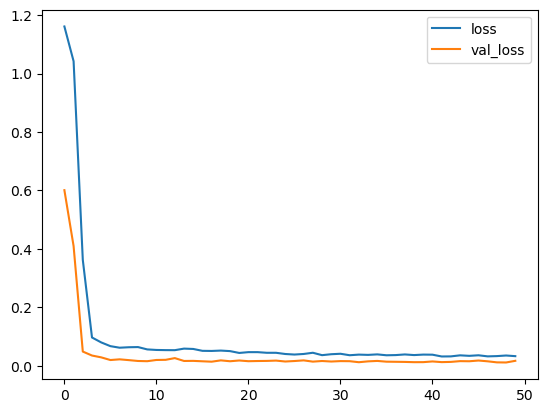

In [7]:
# Display training process
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])

In [8]:
model.evaluate(X_test,y_test)


13/13 [==============================] - 0s 3ms/step - loss: 0.0172 - mape: 51.8734


[0.017198411747813225, 51.87343215942383]

13/13 [==============================] - 0s 2ms/step


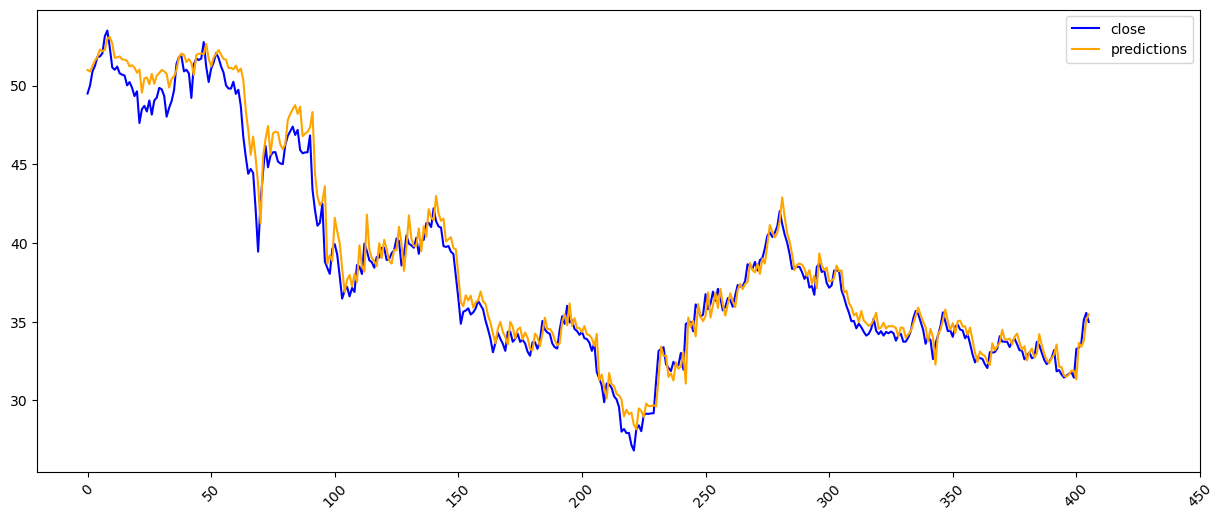

<Figure size 3200x2400 with 0 Axes>

In [10]:
# Predict all slices in the test set in a sequential manner, and check the fit between the predicted results and the true values
pre = model.predict(X_test)
pre_invscaled = scaler_y.inverse_transform(pre)
y_test_invscaled = scaler_y.inverse_transform(y_test)
plt.figure(figsize=(15, 6))
df_time = df.index[-len(y_test):]
plt.plot(df_time,y_test_invscaled,color='blue',label='price')
plt.plot(df_time,pre_invscaled,color='orange',label='predict')
plt.xticks(df_time[::20], rotation = 45)
plt.legend(labels=['close', 'predictions'])
plt.xticks (np.arange (0, 451, 50), np.arange (0, 451, 50))
plt.figure(dpi=500)
plt.show()

In [11]:
#calculate MSE, RMSE
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(pre_invscaled, y_test_invscaled)
rmse = np.sqrt(mse) 
mape = np.mean(np.abs((pre_invscaled - y_test_invscaled) / pre_invscaled)) * 100
from sklearn.metrics import mean_absolute_error
import numpy as np
mae = mean_absolute_error(pre_invscaled, y_test_invscaled)
rmae = np.sqrt(mae)
from sklearn.metrics import r2_score
r2 = r2_score(y_test_invscaled, pre_invscaled)
# Assuming a threshold of 0.1
threshold = 0.1
# Calculate the absolute difference between predicted and true values
diff = np.abs(pre_invscaled - y_test_invscaled)
# Determine if the difference is less than the threshold
correct = diff < threshold
# Calculate accuracy
accuracy = np.mean(correct)
print('MSE of Prediction: ', mse, '\n')
print('RMSE of Prediction: ', rmse)
print('MAPE of Prediction: ', mape)
print('RMAE of Prediction: ', rmae)
print('R^2 of Prediction: ', r2)
print('Accuracy of Prediction: ', accuracy)

MSE of Prediction:  1.1659251626160234 

RMSE of Prediction:  1.0797801455000102
MAPE of Prediction:  2.0413645678966468
RMAE of Prediction:  0.8992952828275913
R^2 of Prediction:  0.9717247371770615
Accuracy of Prediction:  0.08374384236453201
